## Necessary imports

In [34]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Extraction and Processing: Extracting Game of Thrones Episode Data from Wikipedia

In [20]:
# Fetch the HTML content from the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_episodes"
result = requests.get(url)
file = result.text
doc = BeautifulSoup(file, "html.parser")

# Extract relevant tables from the HTML document
tables = doc.find_all("table")

row = []
df = []

# Iterate over each table to extract the data
for table in range(1, 9):
    for i, entry in enumerate(tables[table].find_all("td")):
        row.append(entry.text)  # Append contents of td in row with each iteration
        if (i + 1) % 6 == 0:  # As there are 5 columns in the table
            df.append(row)
            row = []

In [21]:
# Create a DataFrame from the extracted data
df = pd.DataFrame(df, columns=["Episode", "Title", "Season", "4", "5", "U.S. viewers (millions)"])
df

,Episode,Title,Season,4,5,U.S. viewers (millions)
0,1,"""Winter Is Coming""",Tim Van Patten,David Benioff & D. B. Weiss,"April 17, 2011 (2011-04-17)",2.22[21]
1,2,"""The Kingsroad""",Tim Van Patten,David Benioff & D. B. Weiss,"April 24, 2011 (2011-04-24)",2.20[22]
2,3,"""Lord Snow""",Brian Kirk,David Benioff & D. B. Weiss,"May 1, 2011 (2011-05-01)",2.44[23]
3,4,"""Cripples, Bastards, and Broken Things""",Brian Kirk,Bryan Cogman,"May 8, 2011 (2011-05-08)",2.45[24]
4,5,"""The Wolf and the Lion""",Brian Kirk,David Benioff & D. B. Weiss,"May 15, 2011 (2011-05-15)",2.58[25]
...,...,...,...,...,...,...
68,2,"""A Knight of the Seven Kingdoms""",David Nutter,Bryan Cogman,"April 21, 2019 (2019-04-21)",10.29[89]
69,3,"""The Long Night""",Miguel Sapochnik,David Benioff & D. B. Weiss,"April 28, 2019 (2019-04-28)",12.02[90]
70,4,"""The Last of the Starks""",David Nutter,David Benioff & D. B. Weiss,"May 5, 2019 (2019-05-05)",11.80[91]
71,5,"""The Bells""",Miguel Sapochnik,David Benioff & D. B. Weiss,"May 12, 2019 (2019-05-12)",12.48[92]


## Cleaning, Transforming, and Augmenting Game of Thrones Episode Data

In [22]:
# Clean up the DataFrame by removing unwanted characters and columns
df = df.replace("[\{\(\[]+.*[\}\)\]]+", "", regex=True)
df = df.drop(columns=["4", "5"])
df['Title'] = df['Title'].replace('"', '', regex=True)

# Adding corresponding season numbers
lst = [1, 2, 3, 4, 5, 6]
k = 0
for i in range(0, 60, 10):
    df.iloc[i:i + 10, df.columns.get_loc('Season')] = "Season " + str(lst[k])
    k += 1
df.iloc[60:67, df.columns.get_loc('Season')] = "Season 7"
df.iloc[67:, df.columns.get_loc('Season')] = "Season 8"

# Adding "Episode" prefix to the episode numbers
n = df.shape[0]
df.iloc[0:n, df.columns.get_loc('Episode')] = "Episode " + df.iloc[0:n, df.columns.get_loc('Episode')]

# Reorder columns for clarity
df = df.reindex(columns=["Season", "Episode", "Title", "U.S. viewers (millions)"])

# Fetch running times for each episode
tables = doc.find_all("table", {"class": "wikitable plainrowheaders wikiepisodetable"})
rt = []
url = "https://en.m.wikipedia.org/"

# Iterate over the tables to extract running times for each episode
for j in tables:
    for entry in j.find_all("td", {"class": "summary"}):
        a_tag = entry.find("a")
        if a_tag is not None:
            href = a_tag.get("href")
            episode_pg = requests.get(url + href)
            if episode_pg.status_code == 200:
                episode_pg = BeautifulSoup(episode_pg.text)
                try:
                    for item in episode_pg.find_all("td"):
                        if "minutes" in item.text:
                            rt.append(item.text)
                except:
                    rt.append(None)
            time.sleep(.5)

# Extract the minutes from running time and assign it to the DataFrame
for o in range(len(rt)):
    rt[o] = rt[o][:2]
df["Running time (in mins)"] = rt

In [27]:
df.head(10)

,Season,Episode,Title,U.S. viewers (millions),Running time (in mins)
0,Season 1,Episode 1,Winter Is Coming,2.22,61
1,Season 1,Episode 2,The Kingsroad,2.20,55
2,Season 1,Episode 3,Lord Snow,2.44,57
3,Season 1,Episode 4,"Cripples, Bastards, and Broken Things",2.45,55
4,Season 1,Episode 5,The Wolf and the Lion,2.58,54
5,Season 1,Episode 6,A Golden Crown,2.44,52
6,Season 1,Episode 7,You Win or You Die,2.40,57
7,Season 1,Episode 8,The Pointy End,2.72,58
8,Season 1,Episode 9,Baelor,2.66,56
9,Season 1,Episode 10,Fire and Blood,3.04,52


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Season                   73 non-null     object
 1   Episode                  73 non-null     object
 2   Title                    73 non-null     object
 3   U.S. viewers (millions)  73 non-null     object
 4   Running time (in mins)   73 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.0+ KB


In [32]:
# convert columns to appropriate data type
df['Running time (in mins)'] = pd.to_numeric(df['Running time (in mins)'])
df['U.S. viewers (millions)'] = pd.to_numeric(df['U.S. viewers (millions)'])

## Visualizations

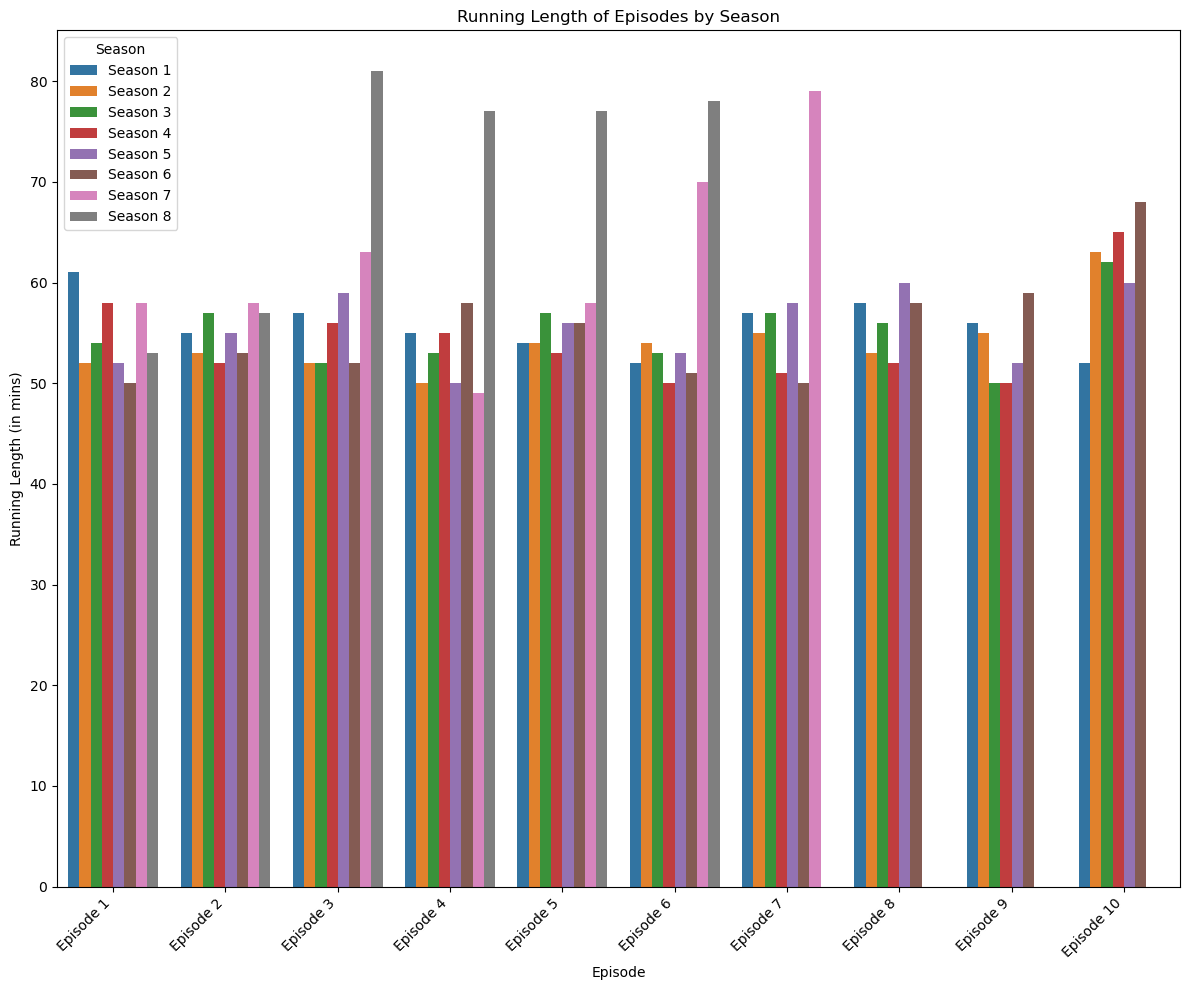

In [35]:
# Create the plot
plt.figure(figsize=(12, 10))
sns.barplot(x='Episode', y='Running time (in mins)', hue='Season', data=df)

# Customize the plot
plt.title('Running Length of Episodes by Season')
plt.xlabel('Episode')
plt.ylabel('Running Length (in mins)')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.legend(title='Season')
plt.show()

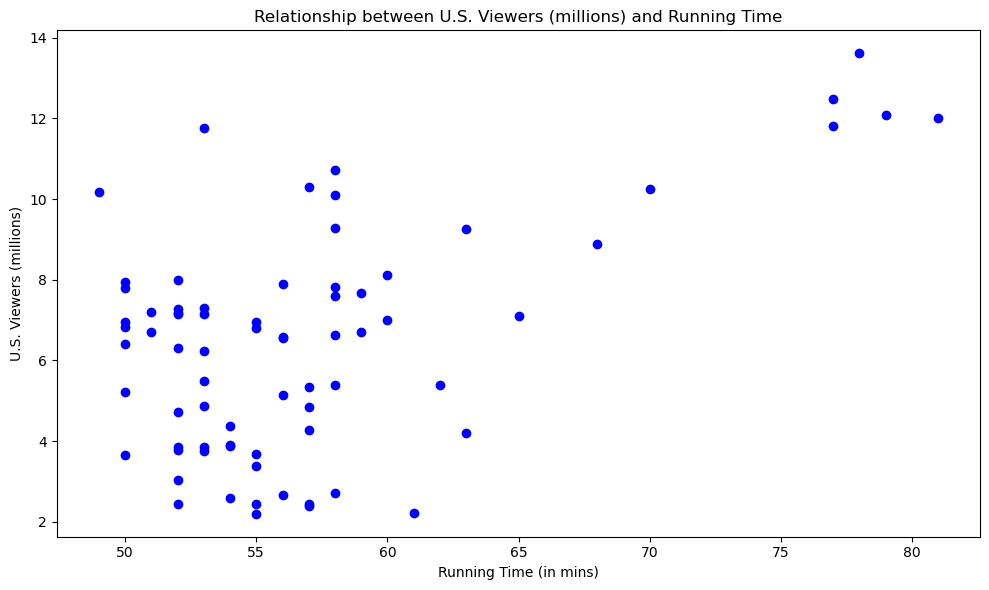

In [38]:
# Extract the required data from the DataFrame
us_viewers = df['U.S. viewers (millions)']
running_time = df['Running time (in mins)']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(running_time, us_viewers, color='blue')

# Customize the plot
plt.title('Relationship between U.S. Viewers (millions) and Running Time')
plt.xlabel('Running Time (in mins)')
plt.ylabel('U.S. Viewers (millions)')

# Display the plot
plt.tight_layout()
plt.show()

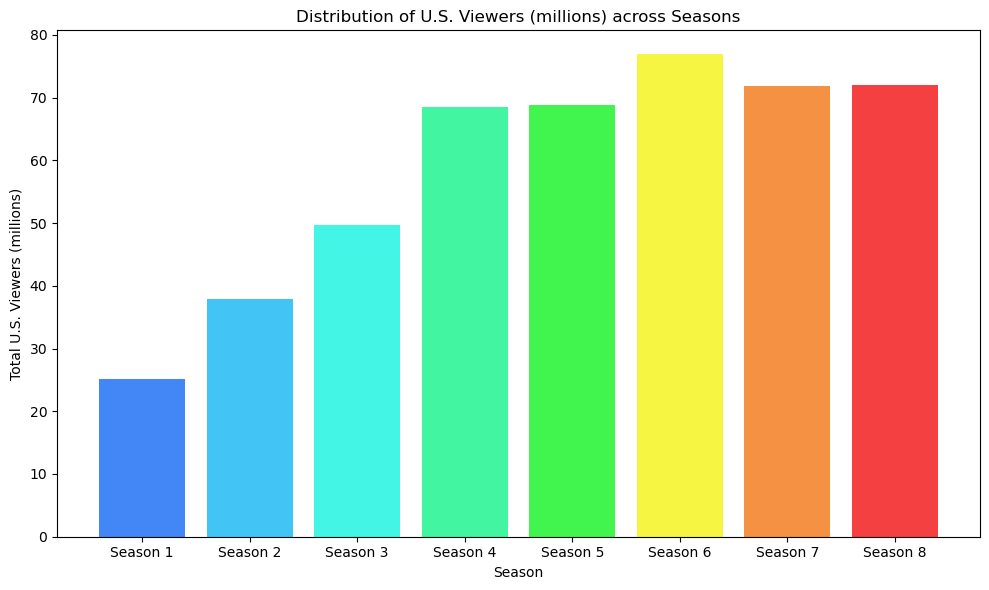

In [39]:
# Group the data by season and calculate the total viewership
season_data = df.groupby('Season')['U.S. viewers (millions)'].sum()

# Extract the seasons and viewership values
seasons = season_data.index
viewership = season_data.values

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(seasons, viewership, color=['#4287f5', '#42c5f5', '#42f5e5', '#42f5a1', '#42f54e', '#f5f542', '#f59142', '#f54042'])

# Customize the plot
plt.title('Distribution of U.S. Viewers (millions) across Seasons')
plt.xlabel('Season')
plt.ylabel('Total U.S. Viewers (millions)')

# Display the plot
plt.tight_layout()
plt.show()

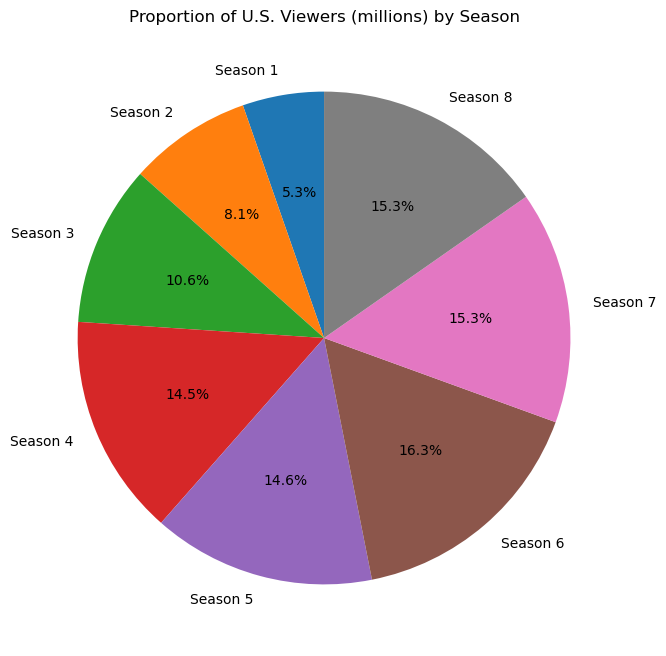

In [42]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(viewership, labels=seasons, autopct='%1.1f%%', startangle=90)

# Customize the plot
plt.title('Proportion of U.S. Viewers (millions) by Season')

# Display the plot
plt.show()